<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# Analysis

In [1]:
import os, sys, re, json, nltk
from math import sqrt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from scipy.sparse import hstack
import scipy.stats as stats
from copy import deepcopy
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# all LIWC fields
ALL_FIELDS = [
    'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 
    'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 
    'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 
    'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 
    'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 
    'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 
    'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 
    'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 
    'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 
    'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 
    'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 
    'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 
    'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period', 
    'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 
    'Apostro', 'Parenth', 'OtherP'
]

# all LIWC fields used in Hirschmuller and Egloff study
MS_FIELDS = [
    "i", "we", "you", "they", "anx", "anger", "sad", "social", "family", 
    "friend", "cogproc", "focuspast", "focuspresent", "focusfuture",
    "relig", "death"
]
    
    
def read_csv(f, index="id", parse_dates=None):
    """Read in csv and return data frame."""
    
    df = pd.read_csv(f, encoding="ISO-8859-1", infer_datetime_format=True,
                     parse_dates=parse_dates)
    df.set_index(index, inplace=True)
    df.index = df.index.map(str)
    return df


def get_liwc(df, fields=None, binary=False):
    """Return LIWC features."""
    
    # detect overall sentiment
    #df2 = df.copy() # prevent SettingWithCopyWarning
    #sent = df2['posemo'] - df2['negemo']
    #df2.loc[:,'posemo'] = np.where(sent > 0., 1, 0)
    #df2.loc[:,'negemo'] = np.where(sent < 0., 1, 0)
    
    # set fields
    if fields is None: fields = ALL_FIELDS
        
    # get matrix
    X = df2[fields].as_matrix()
    if binary:
        X = (X > 0).astype(int)
    print("X.shape: {}".format(X.shape))
    print("X: {}".format(X))
    return X 


def add_liwc(X, df, fields=None, binary=False):
    """Add fields to X from df."""
    
    X_liwc = get_liwc(df, fields, binary)
    return hstack((X, X_liwc))


def calc_cohens_d(x, y):
    """Return Cohen's d value, an effect size used to indicate the 
       standardized difference between two means:
       
       Effect size 	d
       Very small 	0.01
       Small      	0.20
       Medium     	0.50
       Large      	0.80
       Very large 	1.20
       Huge       	2.0
    """
    
    return (x.mean() - y.mean()) / (sqrt((x.std() ** 2 + y.std() ** 2) / 2))


def calc_ttest(x, y, ind=True, **kargs):
    """Return paired t-test stats: r and p:
    
       The greater the T value (r), the more evidence you have 
       that the samples are significantly different from average. 
       A smaller T value is evidence that your samples are not 
       significantly different from average. 
       
       The p-value is the evidence against a null hypothesis. The smaller the 
       p-value, the strong the evidence that you should reject the null hypothesis.
       A small p (≤ 0.05), reject the null hypothesis. This is strong evidence 
       that the null hypothesis is invalid. A large p (> 0.05) means the alternate 
       hypothesis is weak, so you do not reject the null.
       
       For example, a p value of 0.0254 is 2.54%. This means there is a 2.54% 
       chance your results could be random (i.e. happened by chance). That’s 
       pretty tiny. On the other hand, a large p-value of .9(90%) means your 
       results have a 90% probability of being completely random and not due 
       to anything in your experiment. Therefore, the smaller the p-value, 
       the more important (“significant”) your results."""
    
    if ind: t = stats.ttest_ind(x, y, **kargs)
    else: t = stats.ttest_rel(x, y, **kargs)
    return t.statistic, t.pvalue


def get_samp_stats(x, y, ind=True, **kargs):
    """Return paired t-test stats and Cohen's d."""
    
    r, p = calc_ttest(x, y, ind=ind, **kargs)
    d = calc_cohens_d(x, y)
    return r, p, d


def get_corr_stats(x, y):
    """Calculates a Pearson correlation coefficient and the p-value for 
       testing non-correlation:
       
       Effect size 	r
       Small 	0.10
       Medium 	0.30
       Large 	0.50
       """
    return stats.pearsonr(x, y)


def print_samp_stats(x, y, ind=True, **kargs):
    r, p, d = get_samp_stats(x, y, ind=ind, **kargs)
    print("Paired t-test stats:")
    print("   N, r, p, d: {} {} {} {}".format(len(x), r, p, d))
    
    
def print_corr_stats(x, y):
    r, p = get_corr_stats(x, y)
    print("Pearson's correlation:")
    print("  r, p: {} {}".format(r, p))
    
    
def highlight_sig_corrs(s, threshold=0.05, column=['p']):
    """Hightlight significant correlations."""
    
    sig = pd.Series(data=False, index=s.index)
    sig[column] = s.loc[column] < threshold
    #return ['background-color: yellow' if sig.any() else '' for v in sig]
    return ['font-weight: bold' if sig.any() else '' for v in sig]


def get_t2_table(x, fields=['WC', 'Dic', 'posemo', 'negemo']):
    """Generate stats as shown in table 2 if Hirschmuller 
       and Egloff study."""
    
    t2_stats = {}
    for liwc in fields:
        t2_stats.setdefault('LIWC variables', []).append(liwc)
        t2_stats.setdefault('M', []).append(x[liwc].mean())
        t2_stats.setdefault('SD', []).append(x[liwc].std())
        t2_stats.setdefault('Min', []).append(x[liwc].min())
        t2_stats.setdefault('Max', []).append(x[liwc].max())
    t2_df = pd.DataFrame(t2_stats, columns=['LIWC variables', 'M', 'SD', 
                                            'Min', 'Max']).set_index('LIWC variables')
    return t2_df


def get_t4_table(x, corr_field, fields=MS_FIELDS):
    """Generate stats as shown in table 4 if Hirschmuller 
       and Egloff study."""
    
    t4_stats = {}
    for liwc in fields:
        t4_stats.setdefault('LIWC variables', []).append(liwc)
        t4_stats.setdefault('M', []).append(x[liwc].mean())
        t4_stats.setdefault('SD', []).append(x[liwc].std())
        r, p = get_corr_stats(x[corr_field], x[liwc])
        t4_stats.setdefault('r', []).append(r)
        t4_stats.setdefault('p', []).append(p)
    t4_df = pd.DataFrame(t4_stats, columns=['LIWC variables', 'M', 'SD', 
                                            'r', 'p']).set_index('LIWC variables')
    return t4_df.style.apply(highlight_sig_corrs, axis=1, subset=['r', 'p'])

In [2]:
# hawaii missile crisis data
hmc_file = "data/hawaii_missile_crisis-all-labelled-LIWC2015.csv"
hmc_df = read_csv(hmc_file, parse_dates=['created_at'])

# inferred mortality salience data
ms_file = "data/ms_tweets-predicted_mortality_salience-hiscore-verified.csv"
ms_df = read_csv(ms_file, parse_dates=['created_at'])

# UTC time of missile threat alert (start of the crisis period)
crisis_start = datetime(2018, 1, 13, 18, 7, 0) # 2018-1-13 08:07AM HST

# UTC time of initial cancellation (end of the crisis period)
crisis_end = datetime(2018, 1, 13, 18, 21, 0) # 2018-1-13 08:21AM HST

# all tweets geolocated in Hawaii during crisis period
hi_crisis_df = hmc_df[(hmc_df['created_at'] >= crisis_start) &
                      (hmc_df['created_at'] <= crisis_end)].sort_values(by=['created_at'])
print("all HI tweets between {} and {}: {}".format(crisis_start, crisis_end, len(hi_crisis_df)))

# missile threat-related tweets (mortality salience) gelocated in Hawaii 
# during crisis period
hi_crisis_ms_df = hi_crisis_df[hi_crisis_df['mortality_salience'] == 1]
print("missile threat HI tweets between {} and {}: {}".format(crisis_start, crisis_end, 
                                                              len(hi_crisis_ms_df)))
print("percent tweeted about missile threat during crisis period: {}".format(
    len(hi_crisis_ms_df)/len(hi_crisis_df)))

# merge inferred mortality salience data with geolocated mortality salience data
inferred_crisis_ms_df = ms_df[ms_df['mortality_salience'] == 1]
print("number of inferred tweets: {}".format(len(inferred_crisis_ms_df)))
hi_crisis_ms_df = pd.concat([hi_crisis_ms_df, inferred_crisis_ms_df])
print("total mortality salience tweets geolocated in HI or inferred in HI: {}".format(
    len(hi_crisis_ms_df)))

all HI tweets between 2018-01-13 18:07:00 and 2018-01-13 18:21:00: 421
missile threat HI tweets between 2018-01-13 18:07:00 and 2018-01-13 18:21:00: 390
percent tweeted about missile threat during crisis period: 0.9263657957244655
number of inferred tweets: 16
total mortality salience tweets geolocated in HI or inferred in HI: 406


In [3]:
# death row statements
tex_labelled_file = "data/offenders-LIWC2015-clean_and_labelled.csv"
tex_labelled_file_2007 = "data/offenders-LIWC2007-clean_and_labelled.csv"
fields = deepcopy(ALL_FIELDS)
fields.insert(0, 'mortality_salience')
fields.insert(0, 'text')
tex_df = read_csv(tex_labelled_file, parse_dates=['created_at'])[fields]
tex_df_2007 = read_csv(tex_labelled_file_2007, parse_dates=['created_at'])
print("all death row final statements: {}".format(len(tex_df)))

# print stats as shown in table 2 if Hirschmuller and Egloff study using LIWC2007
display(get_t2_table(tex_df_2007))

# run paired t-test on 2007 data as in results of their study
print_samp_stats(tex_df_2007['posemo'], tex_df_2007['negemo'])

# print stats as shown in table 2 if Hirschmuller and Egloff study
display(get_t2_table(tex_df))
    
# run paired t-test on 2015 data as in results of their study
print_samp_stats(tex_df['posemo'], tex_df['negemo'])

# t-test between versions of LIWC
print_samp_stats(tex_df_2007['posemo'], tex_df['posemo'], ind=False)
print_samp_stats(tex_df_2007['negemo'], tex_df['negemo'], ind=False)

all death row final statements: 424


,M,SD,Min,Max
LIWC variables,,,,
WC,97.735849,107.549147,1.0,1269.00
Dic,88.767500,13.003336,0.0,100.00
posemo,9.103561,7.176709,0.0,100.00
negemo,2.581981,2.904777,0.0,20.83


Paired t-test stats:
   N, r, p, d: 424 17.344705901193496 6.845993474334478e-58 1.1912392920560468


,M,SD,Min,Max
LIWC variables,,,,
WC,96.363208,107.287599,1.0,1269.00
Dic,92.401179,7.870194,0.0,100.00
posemo,9.028278,7.192717,0.0,100.00
negemo,2.671250,3.013741,0.0,21.43


Paired t-test stats:
   N, r, p, d: 424 16.78501190733817 8.542737353410589e-55 1.1527993507387169
Paired t-test stats:
   N, r, p, d: 424 1.0929618810915125 0.2750325884621147 0.01047821509038084
Paired t-test stats:
   N, r, p, d: 424 -4.639929454099013 4.654903190996644e-06 -0.030160841669236802


In [4]:
# show similar stats for HI crisis tweets
display(get_t2_table(hi_crisis_ms_df))

# run paired t-test
print_samp_stats(hi_crisis_ms_df['negemo'], hi_crisis_ms_df['posemo'])

,M,SD,Min,Max
LIWC variables,,,,
WC,11.815271,6.258061,1.0,31.00
Dic,62.560911,20.376842,0.0,100.00
posemo,3.039433,6.286583,0.0,33.33
negemo,5.517069,10.005447,0.0,100.00


Paired t-test stats:
   N, r, p, d: 406 4.224846155470106 2.6626651342512903e-05 0.2965260689109739


From the above table and t-test, we see that in the HI crisis tweet dataset slightly more negative emotion words were used during the period of emminent death.

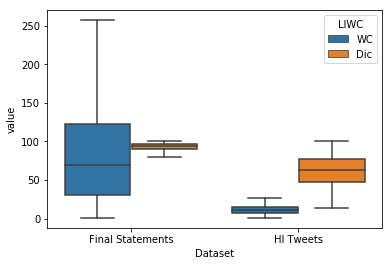

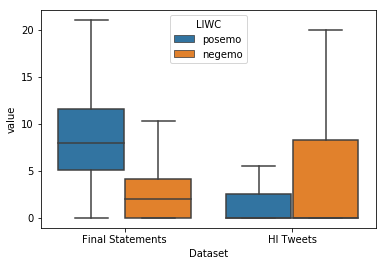

In [5]:
# plot differences
for liwc in [['WC', 'Dic'], ['posemo', 'negemo']]:
    b1 = tex_df[liwc].assign(Dataset="Final Statements")
    b2 = hi_crisis_ms_df[liwc].assign(Dataset="HI Tweets")
    cdf = pd.concat([b1, b2])
    mdf = pd.melt(cdf, id_vars=['Dataset'], var_name=['LIWC'])
    ax = sns.boxplot(x="Dataset", y="value", hue="LIWC", data=mdf, showfliers=False)    
    plt.show()

Plots also show that more negative emotion words are used as people are trying to cope with mortality salience.

In [6]:
# print stats as shown in table 4 if Hirschmuller and Egloff study
display(get_t4_table(tex_df, 'posemo'))

,M,SD,r,p
LIWC variables,,,,
i,12.7671,5.49022,0.121196,0.0125097
we,0.46408,1.22697,-0.0673539,0.166242
you,5.55785,4.83172,0.156868,0.00119257
they,0.829858,1.7647,-0.0537566,0.269399
anx,0.167052,0.582257,-0.122135,0.0118384
anger,0.655307,1.42347,-0.147642,0.00230458
sad,1.12292,1.87795,-0.150752,0.00185307
social,18.3342,10.4982,0.202189,2.7355e-05
family,2.21632,3.04797,0.134061,0.00569537


In [7]:
# show similar stats for hawaii tweets
# print stats as shown in table 4 if Hirschmuller and Egloff study
display(get_t4_table(hi_crisis_ms_df, 'posemo'))

,M,SD,r,p
LIWC variables,,,,
i,3.04697,5.6881,-0.0606753,0.222492
we,1.56187,4.99033,0.0490013,0.324675
you,1.0267,3.6119,0.182186,0.000223766
they,0.133448,0.965583,-0.0292762,0.556394
anx,2.04658,5.53794,-0.117508,0.0178537
anger,3.85473,9.01259,-0.124438,0.0120941
sad,0.0806897,0.750554,0.0104023,0.834479
social,6.55534,10.7097,0.12523,0.0115537
family,0.407857,2.40924,0.0285169,0.566682


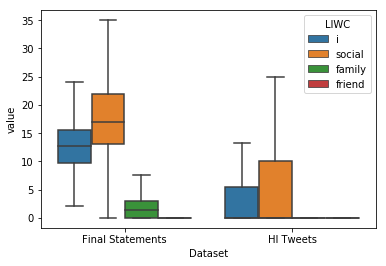

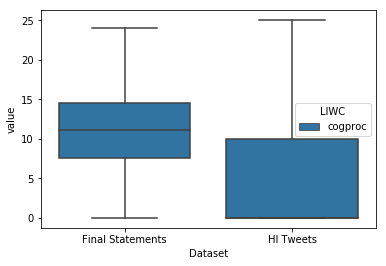

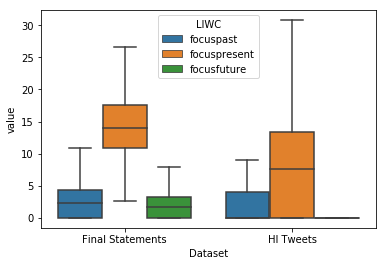

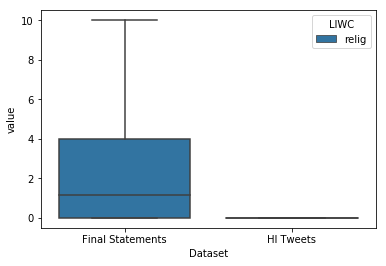

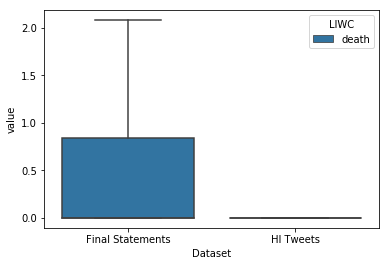

In [8]:
for liwc in [['i', 'social', 'family', 'friend'], ['cogproc'], ['focuspast', 
             'focuspresent', 'focusfuture'], ['relig'], ['death']]:
    b1 = tex_df[liwc].assign(Dataset="Final Statements")
    b2 = hi_crisis_ms_df[liwc].assign(Dataset="HI Tweets")
    cdf = pd.concat([b1, b2])
    mdf = pd.melt(cdf, id_vars=['Dataset'], var_name=['LIWC'])
    ax = sns.boxplot(x="Dataset", y="value", hue="LIWC", data=mdf, showfliers=False)    
    plt.show()

In [9]:
# print stats as shown in table 4 if Hirschmuller and Egloff study for all
for sent in ['posemo', 'negemo']:
    display(get_t4_table(tex_df, sent, fields=ALL_FIELDS))

,M,SD,r,p
LIWC variables,,,,
WC,96.3632,107.288,-0.210706,1.21375e-05
Analytic,29.5793,24.929,0.0639566,0.18871
Clout,67.4962,29.0664,0.201666,2.87231e-05
Authentic,51.8893,30.1916,-0.113937,0.0189337
Tone,73.8996,35.3735,0.511589,1.17886e-29
WPS,10.3693,4.84046,-0.270849,1.4538e-08
Sixltr,9.87811,7.07732,-0.128938,0.00785437
Dic,92.4012,7.87019,0.118834,0.0143489
function,56.8121,9.16636,-0.404675,3.87674e-18


,M,SD,r,p
LIWC variables,,,,
WC,96.3632,107.288,0.0384956,0.429162
Analytic,29.5793,24.929,-0.138637,0.00423497
Clout,67.4962,29.0664,-0.162749,0.000768876
Authentic,51.8893,30.1916,0.0315072,0.51762
Tone,73.8996,35.3735,-0.612574,4.95132e-45
WPS,10.3693,4.84046,0.0487588,0.316519
Sixltr,9.87811,7.07732,0.000631726,0.989652
Dic,92.4012,7.87019,0.171081,0.000402414
function,56.8121,9.16636,0.21476,8.14673e-06


In [10]:
# do same for hawaii tweets
for sent in ['posemo', 'negemo']:
    display(get_t4_table(hi_crisis_ms_df, sent, fields=ALL_FIELDS))

/Users/gmanipon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,M,SD,r,p
LIWC variables,,,,
WC,11.8153,6.25806,-0.117997,0.0173802
Analytic,61.8015,32.4351,-0.0384192,0.4401
Clout,46.1946,32.8246,0.218498,8.87856e-06
Authentic,29.8858,34.7965,-0.062702,0.207397
Tone,30.9449,34.5088,0.772703,9.25249e-82
WPS,7.65108,4.49525,-0.0830247,0.0947952
Sixltr,15.9352,11.6959,-0.0895569,0.071454
Dic,62.5609,20.3768,0.0618935,0.213327
function,33.513,17.6371,-0.161864,0.00106404


,M,SD,r,p
LIWC variables,,,,
WC,11.8153,6.25806,-0.227359,3.6962e-06
Analytic,61.8015,32.4351,0.0854448,0.0855227
Clout,46.1946,32.8246,-0.213942,1.37409e-05
Authentic,29.8858,34.7965,-0.101578,0.0407831
Tone,30.9449,34.5088,-0.429126,1.27833e-19
WPS,7.65108,4.49525,-0.137039,0.00567833
Sixltr,15.9352,11.6959,0.0597995,0.229252
Dic,62.5609,20.3768,0.211203,1.77863e-05
function,33.513,17.6371,-0.124882,0.0117884


In [11]:
# let analyse differences between HI tweets during crisis and our control dates:
# A Saturday one year before the crisis and a Saturday 3 months after

# UTC start and end time of missile threat alert day
crisis_day_start = datetime(2018, 1, 13, 0, 0, 0) # 2018-1-13
crisis_day_end = datetime(2018, 1, 13, 23, 59, 59)

hi_ctrl_df = hmc_df[(hmc_df['created_at'] < crisis_day_start) |
                    (hmc_df['created_at'] > crisis_day_end)].sort_values(by=['created_at'])
print("all HI control tweets: {}".format(len(hi_ctrl_df)))

all HI control tweets: 7489


In [12]:
# print table 2 stats for HI control
display(get_t2_table(hi_ctrl_df))

# run paired t-test
print_samp_stats(hi_ctrl_df['posemo'], hi_ctrl_df['negemo'])

,M,SD,Min,Max
LIWC variables,,,,
WC,15.486981,7.609466,1.0,59.0
Dic,61.242106,21.406095,0.0,100.0
posemo,4.219057,7.717543,0.0,100.0
negemo,2.240005,6.321268,0.0,100.0


Paired t-test stats:
   N, r, p, d: 7489 17.16786581685261 1.952565762967699e-65 0.2805558913064131


In [13]:
# let's compare t-test HI tweets during crisis
print("*** HI Control posemo vs. negemo ***:")
print_samp_stats(hi_ctrl_df['posemo'], hi_ctrl_df['negemo'])
print("*** HI Crisis  posemo vs. negemo ***:")
print_samp_stats(hi_crisis_ms_df['posemo'], hi_crisis_ms_df['negemo'])
print("*** posemo HI crisis vs. ctrl ***:")
print_samp_stats(hi_crisis_ms_df['posemo'], hi_ctrl_df['posemo'])
print("*** negemo HI crisis vs. ctrl ***:")
print_samp_stats(hi_crisis_ms_df['negemo'], hi_ctrl_df['negemo'])

*** HI Control posemo vs. negemo ***:
Paired t-test stats:
   N, r, p, d: 7489 17.16786581685261 1.952565762967699e-65 0.2805558913064131
*** HI Crisis  posemo vs. negemo ***:
Paired t-test stats:
   N, r, p, d: 406 -4.224846155470106 2.6626651342512903e-05 -0.2965260689109739
*** posemo HI crisis vs. ctrl ***:
Paired t-test stats:
   N, r, p, d: 406 -3.0258323426620213 0.0024874855144683735 -0.1675953690161852
*** negemo HI crisis vs. ctrl ***:
Paired t-test stats:
   N, r, p, d: 406 9.802192057076015 1.4812973523614514e-22 0.3915897579412899


In [14]:
# print stats as shown in table 4 if Hirschmuller and Egloff study for all
for sent in ['posemo', 'negemo']:
    display(get_t4_table(hi_ctrl_df, sent, fields=ALL_FIELDS))

,M,SD,r,p
LIWC variables,,,,
WC,15.487,7.60947,-0.173586,9.59655e-52
Analytic,66.129,33.7245,-0.0500457,1.47159e-05
Clout,54.0572,31.4871,0.0361961,0.001731
Authentic,32.4028,37.3165,-0.0540978,2.81024e-06
Tone,46.267,37.1544,0.650608,0
WPS,11.2287,6.53091,-0.162958,9.86299e-46
Sixltr,19.949,14.3621,0.0645919,2.21094e-08
Dic,61.2421,21.4061,0.16029,2.75904e-44
function,30.6083,17.9743,-0.0603144,1.75636e-07


,M,SD,r,p
LIWC variables,,,,
WC,15.487,7.60947,-0.192671,1.50523e-63
Analytic,66.129,33.7245,-0.147684,8.735e-38
Clout,54.0572,31.4871,-0.165552,3.65649e-47
Authentic,32.4028,37.3165,0.0549017,1.99501e-06
Tone,46.267,37.1544,-0.358375,8.45872e-226
WPS,11.2287,6.53091,-0.133117,5.88667e-31
Sixltr,19.949,14.3621,-0.00694861,0.547685
Dic,61.2421,21.4061,0.234933,1.94484e-94
function,30.6083,17.9743,0.0789178,7.97521e-12


# Results

Study by Hirschmuller showed that in the Texas death row final statements, positive emotion words were used at a significantly higher percentage than negative words:

In [15]:
# run paired t-test on 2015 data as in results of their study
print_samp_stats(tex_df['posemo'], tex_df['negemo'])

Paired t-test stats:
   N, r, p, d: 424 16.78501190733817 8.542737353410589e-55 1.1527993507387169


In our study of tweets during the crisis period of the HI missile threat alert, negative emotion words were used at a slightly higher percentage than positive words:

In [16]:
# run paired t-test on HI crisis tweets
print_samp_stats(hi_crisis_ms_df['posemo'], hi_crisis_ms_df['negemo'])

Paired t-test stats:
   N, r, p, d: 406 -4.224846155470106 2.6626651342512903e-05 -0.2965260689109739


To compare to a baseline, we run a t-test on tweets in HI one year prior and 3 months after the crisis on the same day (Saturday):

In [17]:
# run paired t-test on HI control
print_samp_stats(hi_ctrl_df['posemo'], hi_ctrl_df['negemo'])

Paired t-test stats:
   N, r, p, d: 7489 17.16786581685261 1.952565762967699e-65 0.2805558913064131


Now comparing postive emotion words used during the crisis vs. the control times:

In [18]:
print("*** posemo HI crisis vs. ctrl ***:")
print_samp_stats(hi_crisis_ms_df['posemo'], hi_ctrl_df['posemo'])

*** posemo HI crisis vs. ctrl ***:
Paired t-test stats:
   N, r, p, d: 406 -3.0258323426620213 0.0024874855144683735 -0.1675953690161852


and comparing negative emotion words used during the crisis vs. the control times:

In [19]:
print("*** negemo HI crisis vs. ctrl ***:")
print_samp_stats(hi_crisis_ms_df['negemo'], hi_ctrl_df['negemo'])

*** negemo HI crisis vs. ctrl ***:
Paired t-test stats:
   N, r, p, d: 406 9.802192057076015 1.4812973523614514e-22 0.3915897579412899


We see that during the crisis, significantly less positive words were used in tweets than during the control periods while significantly more negative words were used during the crisis.

The Hirschmuller study showed that the use of positive emotional language is associated with language use indicative of self-references, social orientation, cognitive processing, time orientation, and personal concerns with religion and death:

In [20]:
# print stats as shown in table 4 if Hirschmuller and Egloff study
display(get_t4_table(tex_df, 'posemo'))

,M,SD,r,p
LIWC variables,,,,
i,12.7671,5.49022,0.121196,0.0125097
we,0.46408,1.22697,-0.0673539,0.166242
you,5.55785,4.83172,0.156868,0.00119257
they,0.829858,1.7647,-0.0537566,0.269399
anx,0.167052,0.582257,-0.122135,0.0118384
anger,0.655307,1.42347,-0.147642,0.00230458
sad,1.12292,1.87795,-0.150752,0.00185307
social,18.3342,10.4982,0.202189,2.7355e-05
family,2.21632,3.04797,0.134061,0.00569537


In our study, we show that emotional negativity in tweets during the missile crisis period is associated with a greater frequency of language use that was indicative of negative emotions related to anger, anxiety, and sadness as well as present-oriented time focus and religion-oriented word use. Both cases show decreased usage of language indicative of cognitive processing but also show increased usage of religious language. 

In [21]:
# print stats as shown in table 4 if Hirschmuller and Egloff study
# include LIWC emotion parameters of anger, anxiety and sadness
display(get_t4_table(hi_crisis_ms_df, 'negemo'))

,M,SD,r,p
LIWC variables,,,,
i,3.04697,5.6881,-9.31092e-05,0.998508
we,1.56187,4.99033,-0.0789263,0.11231
you,1.0267,3.6119,-0.0481212,0.333451
they,0.133448,0.965583,0.00114764,0.981608
anx,2.04658,5.53794,0.509984,2.90321e-28
anger,3.85473,9.01259,0.899013,5.87091e-147
sad,0.0806897,0.750554,0.120614,0.0150281
social,6.55534,10.7097,-0.0923733,0.062955
family,0.407857,2.40924,0.0802818,0.106256


In [22]:
# print stats as shown in table 4 if Hirschmuller and Egloff study for the control
display(get_t4_table(hi_ctrl_df, 'posemo'))

,M,SD,r,p
LIWC variables,,,,
i,4.27055,6.96269,0.00448087,0.698233
we,0.626554,2.23776,-0.0366069,0.00153249
you,1.76129,4.48054,0.0687661,2.56898e-09
they,0.304615,1.69402,0.00845472,0.464441
anx,0.221598,1.94267,-0.03028,0.00877838
anger,1.03317,4.28223,-0.0503915,1.28366e-05
sad,0.467122,2.99862,-0.018795,0.103871
social,7.2323,9.1024,0.109686,1.74338e-21
family,0.474684,2.32257,0.0213581,0.0645713


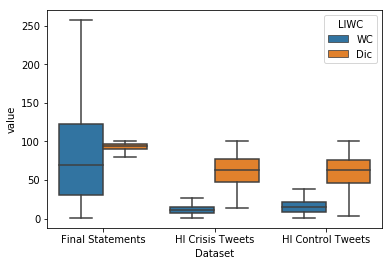

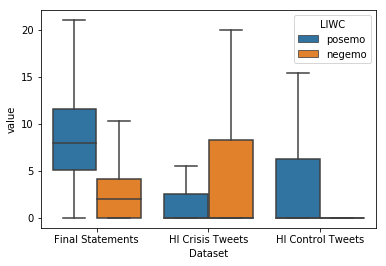

In [23]:
# plot differences
for liwc in [['WC', 'Dic'], ['posemo', 'negemo']]:
    b1 = tex_df[liwc].assign(Dataset="Final Statements")
    b2 = hi_crisis_ms_df[liwc].assign(Dataset="HI Crisis Tweets")
    b3 = hi_ctrl_df[liwc].assign(Dataset="HI Control Tweets")
    cdf = pd.concat([b1, b2, b3])
    mdf = pd.melt(cdf, id_vars=['Dataset'], var_name=['LIWC'])
    ax = sns.boxplot(x="Dataset", y="value", hue="LIWC", data=mdf, showfliers=False)    
    plt.show()